In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [94]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
from fastai.structured import *
from fastai.column_data import *
import utils
from dateutil.parser import parse
from datetime import date, timedelta
import lightgbm as lgb


np.set_printoptions(threshold=50, edgeitems=20)

import utils

# Data fetching

In [5]:
PATH = "../../../data/RRVF/" # "../../../data/RRVF/" "/data/"
RESULT = PATH # result

In [6]:
!ls {PATH}

air_reserve.csv        hpg_reserve.csv        train_set
air_store_info.csv     hpg_store_info.csv     trn_like_data
air_visit_data.csv     models                 ts_prep.pkl
cat_vars.pkl           sample_submission.csv  valid_set
contin_vars.pkl        store_id_relation.csv  weather_data_merge.csv
dataset                test_set
date_info.csv          tmp


In [8]:
splits = pickle.load(open(f'{RESULT}_datasplits.pkl','rb'))
contin_vars = splits['contin_vars']
cat_vars = splits['cat_vars']
X_train = splits['trn']
y_train = splits['trn_y']
X_valid = splits['val']
y_valid = splits['val_y']
X_test = splits['test']

In [14]:
len(X_train)

225049

In [90]:
to_keep

['rolling_air_store_id_visit_Dayofweek_60d_median',
 'hours_sunlight',
 'rolling_genre_name_air_loc_visit_Dayofweek_60d_std',
 'rolling_air_store_id_180d_skew',
 'rolling_genre_name_air_loc_visit_Dayofweek_30d_median',
 'rolling_air_store_id_60d_std',
 'rolling_air_store_id_visit_Dayofweek_60d_std',
 'rolling_air_store_id_visit_Dayofweek_90d_std',
 'af_holiday_flg',
 'rolling_air_store_id_visit_Dayofweek_90d_skew',
 'rolling_air_store_id_90d_std',
 'rolling_genre_name_air_loc_visit_Dayofweek_30d_skew',
 'rolling_air_store_id_visit_Dayofweek_720d_median',
 'rolling_genre_name_air_loc_visit_Dayofweek_30d_mean',
 'rolling_air_store_id_visit_Dayofweek_30d_max',
 'rolling_air_store_id_60d_mean',
 'rolling_air_store_id_visit_Dayofweek_30d_median',
 'rolling_air_store_id_30d_min',
 'rolling_air_store_id_visit_Dayofweek_180d_mean',
 'rolling_genre_name_air_loc_visit_Dayofweek_180d_std',
 'rolling_air_store_id_720d_std',
 'rolling_air_store_id_visit_Dayofweek_180d_std',
 'rolling_genre_name_air

# Random Forest

In [13]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier


def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)
    
def generate_sub(csv_fn, m, df_test):
    pred_test= m.predict(df_test)
    pred_test = np.exp(pred_test)
    test_set['visitors']=pred_test
    trn_like_test = test_set.reset_index()[['air_store_id', 'visit_date', 'visitors']]
    trn_like_test.visit_date = trn_like_test.visit_date.astype('str')
    sub = utils.trn2test(trn_like_test)
    sub.to_csv(csv_fn, index=False)

In [22]:
set_rf_samples(50000)

In [16]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.5110078692244858, 0.5141290107740004, 0.59841208304648452, 0.61058564158287054, 0.56702164469408278]


In [23]:
m = RandomForestRegressor(n_estimators=100, min_samples_leaf=5, max_features=0.6, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.4499448307210461, 0.5070859279162835, 0.6886534953331741, 0.62118178179778427, 0.58173967164053897]


In [130]:


generate_sub('yy_split_sample.csv', m, df_test)

In [36]:
reset_rf_samples()

In [37]:
m = RandomForestRegressor(n_estimators=30, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.2673434892587321, 0.5126637835121219, 0.89008304593489351, 0.61280207935372966, 0.55459379384574037]


In [150]:
generate_sub('yy_split_full.csv', m, df_test)

# Feature Importance

In [24]:
fi = rf_feat_importance(m, X_train); fi[:10]

,cols,imp
64,rolling_air_store_id_visit_Dayofweek_90d_mean,0.344137
83,rolling_air_store_id_visit_Dayofweek_90d_median,0.099100
103,rolling_air_store_id_visit_Dayofweek_180d_mean,0.080217
30,rolling_air_store_id_visit_Dayofweek_60d_mean,0.048945
146,rolling_air_store_id_visit_Dayofweek_180d_median,0.025557
167,rolling_air_store_id_30d_median,0.016501
78,rolling_air_store_id_30d_mean,0.016045
14,be_holiday_flg,0.009563
66,rolling_air_store_id_visit_Dayofweek_30d_mean,0.006637
118,rolling_air_store_id_visit_Dayofweek_720d_mean,0.006080


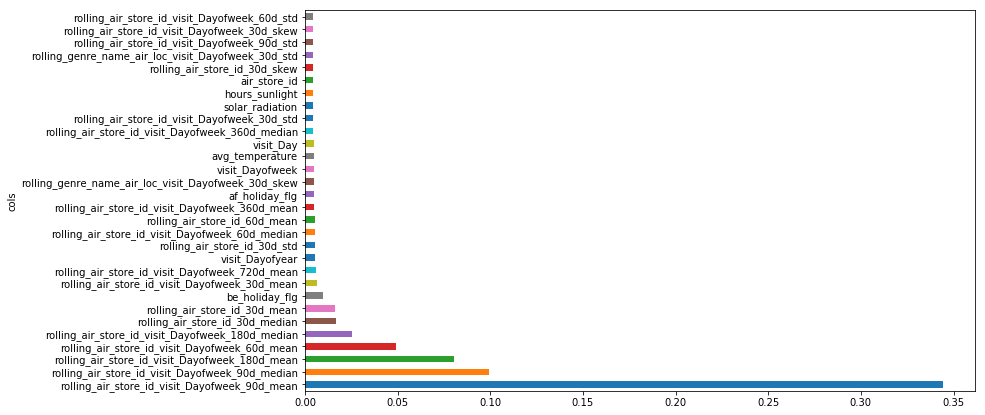

In [25]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)
plot_fi(fi[:30]);

In [38]:
fi[:85].imp.sum(), fi.iloc[85].imp

(0.90363501006765701, 0.0020402117767639363)

In [40]:
to_keep = fi[fi.imp>0.00204].cols; 
to_keep = list(set(to_keep) - set(["visit_Dayofyear"]))
len(to_keep)

85

In [51]:
def evl(df, df_val, to_keep):
    X_train, X_valid = df[to_keep].copy(), df_val[to_keep].copy()
    m = RandomForestRegressor(n_estimators=100, min_samples_leaf=5, max_features=0.6, n_jobs=-1, oob_score=True)
    m.fit(X_train, y_train)
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)
    return m

In [53]:
m = evl(X_train, X_valid, to_keep)

[0.4520226744373265, 0.5068326392666263, 0.68577126136632849, 0.6215601255306501, 0.5804461951119434]


In [49]:
splits["to_keep"] = to_keep
pickle.dump(splits, open(f'{RESULT}_datasplits.pkl','wb'))

# Removing redundant features

In [54]:
from scipy.cluster import hierarchy as hc

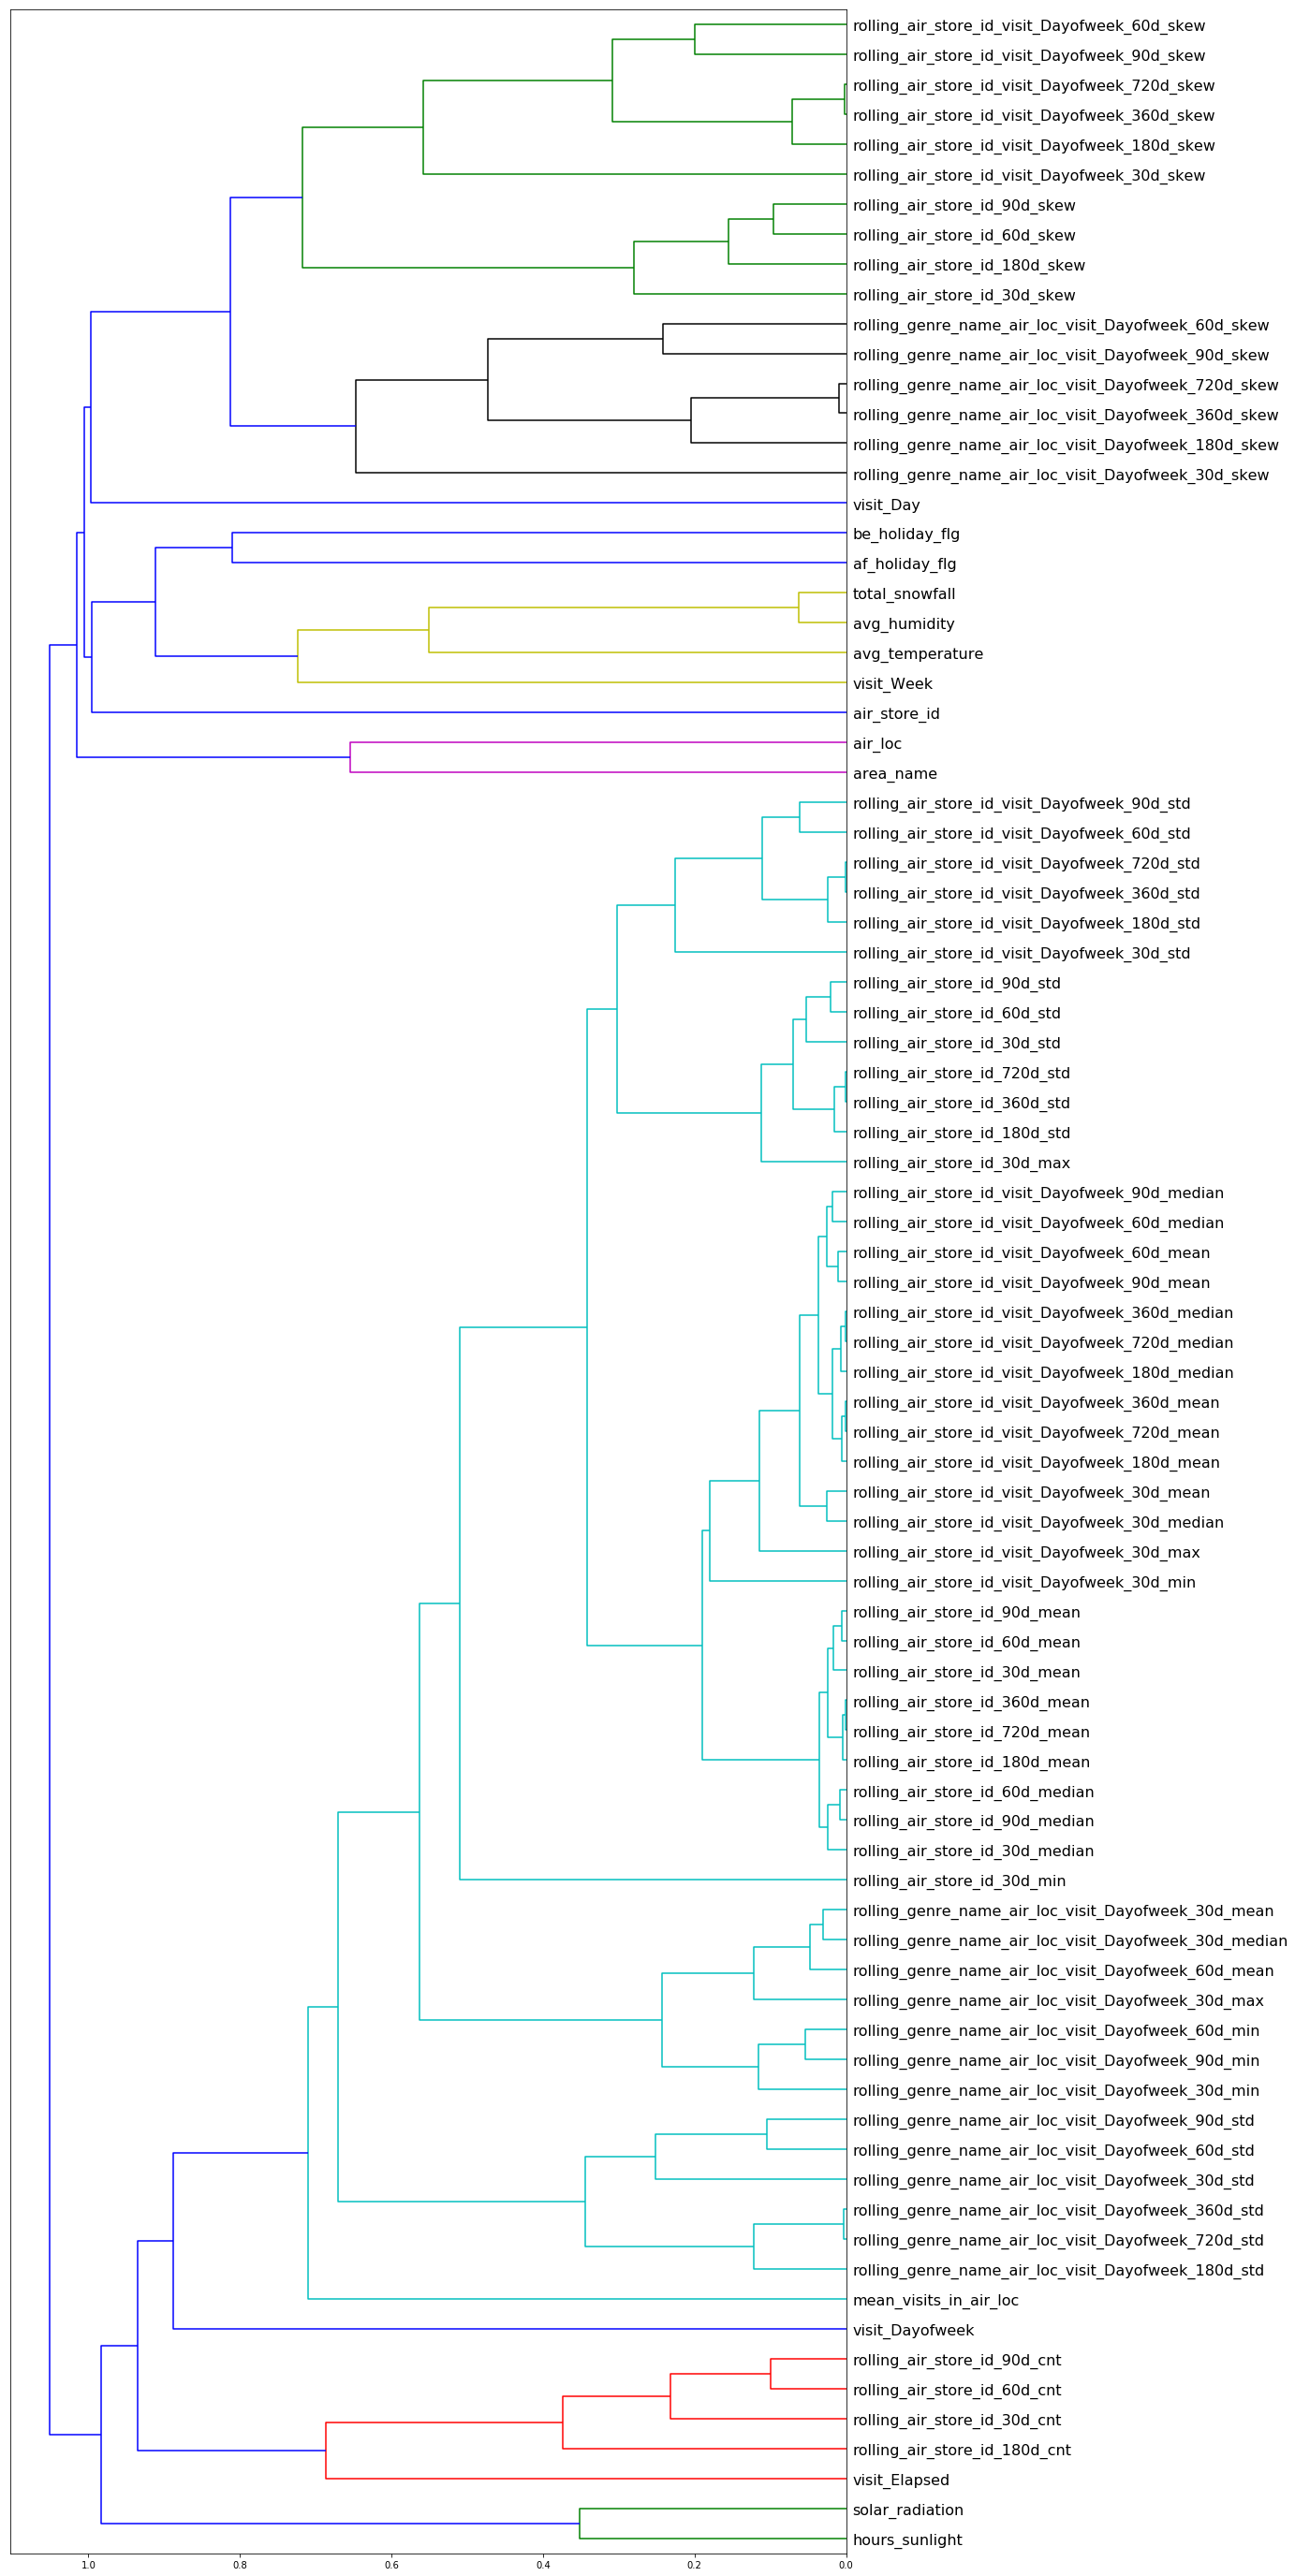

In [58]:
df_keep = X_train[to_keep].copy()
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,50))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.show()

In [59]:
def get_oob(x):
    m = RandomForestRegressor(n_estimators=30, min_samples_leaf=5, max_features=0.6, n_jobs=-1, oob_score=True)
    m.fit(x, y_train)
    return m.oob_score_

In [60]:
get_oob(df_keep)

0.57136500878113838

In [74]:
for c in ('rolling_air_store_id_visit_Dayofweek_720d_skew', 'rolling_air_store_id_visit_Dayofweek_360d_skew', 
          'rolling_genre_name_air_loc_visit_Dayofweek_360d_skew', 'rolling_genre_name_air_loc_visit_Dayofweek_720d_skew', 
          'rolling_air_store_id_visit_Dayofweek_720d_std', 'rolling_air_store_id_visit_Dayofweek_360d_std',
          'rolling_air_store_id_360d_std', 'rolling_air_store_id_720d_std',
          'rolling_air_store_id_visit_Dayofweek_360d_median', 'rolling_air_store_id_visit_Dayofweek_720d_median',
          'rolling_air_store_id_visit_Dayofweek_360d_mean', 'rolling_air_store_id_visit_Dayofweek_720d_mean',
          'rolling_air_store_id_360d_mean', 'rolling_air_store_id_720d_mean',
          'rolling_genre_name_air_loc_visit_Dayofweek_360d_std', 'rolling_genre_name_air_loc_visit_Dayofweek_720d_std',
         ):
    print(c, get_oob(df_keep.drop(c, axis=1)))

rolling_air_store_id_visit_Dayofweek_720d_skew 0.571649421046
rolling_air_store_id_visit_Dayofweek_360d_skew 0.571260642711
rolling_genre_name_air_loc_visit_Dayofweek_360d_skew 0.570655176362
rolling_genre_name_air_loc_visit_Dayofweek_720d_skew 0.571065413281
rolling_air_store_id_visit_Dayofweek_720d_std 0.57128189989
rolling_air_store_id_visit_Dayofweek_360d_std 0.571246756662
rolling_air_store_id_360d_std 0.570668998699
rolling_air_store_id_720d_std 0.572002754888
rolling_air_store_id_visit_Dayofweek_360d_median 0.57104948237
rolling_air_store_id_visit_Dayofweek_720d_median 0.571686599971
rolling_air_store_id_visit_Dayofweek_360d_mean 0.571558357495
rolling_air_store_id_visit_Dayofweek_720d_mean 0.571071522956
rolling_air_store_id_360d_mean 0.57171884385
rolling_air_store_id_720d_mean 0.5716877557
rolling_genre_name_air_loc_visit_Dayofweek_360d_std 0.571189655732
rolling_genre_name_air_loc_visit_Dayofweek_720d_std 0.570864719986


In [73]:
[ col for col in df_keep.columns if 'rolling_genre_name_air_loc_visit_Dayofweek_360d_std' in col]

['rolling_genre_name_air_loc_visit_Dayofweek_360d_std']

In [75]:
to_drop = ['rolling_air_store_id_visit_Dayofweek_360d_skew',
           'rolling_genre_name_air_loc_visit_Dayofweek_360d_skew',
           'rolling_air_store_id_visit_Dayofweek_360d_std',
           'rolling_air_store_id_360d_std',
           'rolling_air_store_id_visit_Dayofweek_360d_median',
           'rolling_air_store_id_visit_Dayofweek_720d_mean',
           'rolling_air_store_id_720d_mean', 
        'rolling_genre_name_air_loc_visit_Dayofweek_720d_std']

In [76]:
get_oob(df_keep.drop(to_drop, axis=1))

0.57154976577217842

In [86]:
to_keep = list( set(to_keep) - set(to_drop) )
len(to_keep)

77

In [87]:
splits["to_keep"] = to_keep
pickle.dump(splits, open(f'{RESULT}_datasplits.pkl','wb'))

In [88]:
reset_rf_samples()

In [89]:
m = evl(X_train, X_valid, to_keep)

[0.30949318314741164, 0.506190156031384, 0.85269155788810425, 0.62251897130263822, 0.57813489570513465]


# LightGBM

In [102]:
splits = pickle.load(open(f'{RESULT}_datasplits.pkl','rb'))
to_keep = splits['to_keep']
contin_vars = list( set(splits['contin_vars']) - set(to_keep) )
cat_vars = list( set(splits['cat_vars']) - set(to_keep))

X_train = splits['trn'][to_keep]
y_train = splits['trn_y']
X_valid = splits['val'][to_keep]
y_valid = splits['val_y']
X_test = splits['test'][to_keep]

In [106]:
lgb_train = lgb.Dataset(X_train, y_train.ravel(), free_raw_data=False) # , categorical_feature=cat_vars 
lgb_eval = lgb.Dataset(X_valid, y_valid.ravel(), reference=lgb_train, free_raw_data=False)

In [125]:
def rmsle(x, y):
    # np.log(targ + 1) - np.log(y_pred + 1)
    return math.sqrt(((x-y)**2).mean())

def rmsle_wo_log(y_predicted, y_true):
    y_true = y_true.get_label()
    score = rmsle(y_predicted, y_true)
    return ('rmsle', score, False)

params = {
        'learning_rate': 0.02,
        'boosting_type': 'gbdt',
        'objective': 'regression',
        # 'metric': 'rmse',
        'sub_feature': 0.7,
        'num_leaves': 90,
        'min_data': 100,
        'min_hessian': 1,
        # 'verbose': -1,
    }

In [126]:
evals_result = {}
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=2300,
                valid_sets=(lgb_train, lgb_eval),
                feval=rmsle_wo_log,
                evals_result=evals_result,
                ) 

[1]	training's rmsle: 0.797385	valid_1's rmsle: 0.814362
[2]	training's rmsle: 0.788721	valid_1's rmsle: 0.805016
[3]	training's rmsle: 0.78025	valid_1's rmsle: 0.795954
[4]	training's rmsle: 0.772001	valid_1's rmsle: 0.787096
[5]	training's rmsle: 0.764002	valid_1's rmsle: 0.778466
[6]	training's rmsle: 0.756282	valid_1's rmsle: 0.770132
[7]	training's rmsle: 0.748726	valid_1's rmsle: 0.762017
[8]	training's rmsle: 0.74142	valid_1's rmsle: 0.754116
[9]	training's rmsle: 0.734312	valid_1's rmsle: 0.746439
[10]	training's rmsle: 0.727481	valid_1's rmsle: 0.738908
[11]	training's rmsle: 0.720761	valid_1's rmsle: 0.731618
[12]	training's rmsle: 0.714286	valid_1's rmsle: 0.724548
[13]	training's rmsle: 0.707964	valid_1's rmsle: 0.71767
[14]	training's rmsle: 0.701893	valid_1's rmsle: 0.711015
[15]	training's rmsle: 0.695938	valid_1's rmsle: 0.704514
[16]	training's rmsle: 0.690174	valid_1's rmsle: 0.698213
[17]	training's rmsle: 0.684628	valid_1's rmsle: 0.692129
[18]	training's rmsle: 0.6

[145]	training's rmsle: 0.515109	valid_1's rmsle: 0.506811
[146]	training's rmsle: 0.514949	valid_1's rmsle: 0.506704
[147]	training's rmsle: 0.514796	valid_1's rmsle: 0.506617
[148]	training's rmsle: 0.514641	valid_1's rmsle: 0.506564
[149]	training's rmsle: 0.514503	valid_1's rmsle: 0.506467
[150]	training's rmsle: 0.514369	valid_1's rmsle: 0.506393
[151]	training's rmsle: 0.514218	valid_1's rmsle: 0.506319
[152]	training's rmsle: 0.514078	valid_1's rmsle: 0.506245
[153]	training's rmsle: 0.513942	valid_1's rmsle: 0.506198
[154]	training's rmsle: 0.513808	valid_1's rmsle: 0.506124
[155]	training's rmsle: 0.513679	valid_1's rmsle: 0.506047
[156]	training's rmsle: 0.513544	valid_1's rmsle: 0.505967
[157]	training's rmsle: 0.513407	valid_1's rmsle: 0.505897
[158]	training's rmsle: 0.513284	valid_1's rmsle: 0.505834
[159]	training's rmsle: 0.513148	valid_1's rmsle: 0.505763
[160]	training's rmsle: 0.513021	valid_1's rmsle: 0.505687
[161]	training's rmsle: 0.512891	valid_1's rmsle: 0.5056

[285]	training's rmsle: 0.501787	valid_1's rmsle: 0.503181
[286]	training's rmsle: 0.501723	valid_1's rmsle: 0.503175
[287]	training's rmsle: 0.501649	valid_1's rmsle: 0.503162
[288]	training's rmsle: 0.501581	valid_1's rmsle: 0.503148
[289]	training's rmsle: 0.501516	valid_1's rmsle: 0.503135
[290]	training's rmsle: 0.501445	valid_1's rmsle: 0.503126
[291]	training's rmsle: 0.501376	valid_1's rmsle: 0.503114
[292]	training's rmsle: 0.501295	valid_1's rmsle: 0.503109
[293]	training's rmsle: 0.501224	valid_1's rmsle: 0.503095
[294]	training's rmsle: 0.50116	valid_1's rmsle: 0.503069
[295]	training's rmsle: 0.50109	valid_1's rmsle: 0.503066
[296]	training's rmsle: 0.501025	valid_1's rmsle: 0.503063
[297]	training's rmsle: 0.500956	valid_1's rmsle: 0.503043
[298]	training's rmsle: 0.500895	valid_1's rmsle: 0.503024
[299]	training's rmsle: 0.500832	valid_1's rmsle: 0.503017
[300]	training's rmsle: 0.500737	valid_1's rmsle: 0.503027
[301]	training's rmsle: 0.500672	valid_1's rmsle: 0.503032

[426]	training's rmsle: 0.493644	valid_1's rmsle: 0.502516
[427]	training's rmsle: 0.493601	valid_1's rmsle: 0.50251
[428]	training's rmsle: 0.493552	valid_1's rmsle: 0.502504
[429]	training's rmsle: 0.493508	valid_1's rmsle: 0.502504
[430]	training's rmsle: 0.493459	valid_1's rmsle: 0.502514
[431]	training's rmsle: 0.493415	valid_1's rmsle: 0.502514
[432]	training's rmsle: 0.493364	valid_1's rmsle: 0.502502
[433]	training's rmsle: 0.493326	valid_1's rmsle: 0.502502
[434]	training's rmsle: 0.493281	valid_1's rmsle: 0.50249
[435]	training's rmsle: 0.493235	valid_1's rmsle: 0.50249
[436]	training's rmsle: 0.493188	valid_1's rmsle: 0.502492
[437]	training's rmsle: 0.493148	valid_1's rmsle: 0.502471
[438]	training's rmsle: 0.493109	valid_1's rmsle: 0.502472
[439]	training's rmsle: 0.493059	valid_1's rmsle: 0.502481
[440]	training's rmsle: 0.493023	valid_1's rmsle: 0.502576
[441]	training's rmsle: 0.49296	valid_1's rmsle: 0.502556
[442]	training's rmsle: 0.492912	valid_1's rmsle: 0.502552
[

[566]	training's rmsle: 0.487402	valid_1's rmsle: 0.502246
[567]	training's rmsle: 0.487367	valid_1's rmsle: 0.502252
[568]	training's rmsle: 0.487328	valid_1's rmsle: 0.502252
[569]	training's rmsle: 0.48728	valid_1's rmsle: 0.502257
[570]	training's rmsle: 0.487241	valid_1's rmsle: 0.50225
[571]	training's rmsle: 0.487195	valid_1's rmsle: 0.502246
[572]	training's rmsle: 0.487151	valid_1's rmsle: 0.502227
[573]	training's rmsle: 0.487112	valid_1's rmsle: 0.502226
[574]	training's rmsle: 0.487076	valid_1's rmsle: 0.502258
[575]	training's rmsle: 0.487032	valid_1's rmsle: 0.502255
[576]	training's rmsle: 0.486987	valid_1's rmsle: 0.502245
[577]	training's rmsle: 0.486948	valid_1's rmsle: 0.502245
[578]	training's rmsle: 0.486893	valid_1's rmsle: 0.502241
[579]	training's rmsle: 0.486859	valid_1's rmsle: 0.502245
[580]	training's rmsle: 0.486817	valid_1's rmsle: 0.502231
[581]	training's rmsle: 0.486775	valid_1's rmsle: 0.502228
[582]	training's rmsle: 0.486731	valid_1's rmsle: 0.502234

[709]	training's rmsle: 0.48156	valid_1's rmsle: 0.502053
[710]	training's rmsle: 0.481535	valid_1's rmsle: 0.502054
[711]	training's rmsle: 0.481474	valid_1's rmsle: 0.502046
[712]	training's rmsle: 0.481425	valid_1's rmsle: 0.502041
[713]	training's rmsle: 0.481397	valid_1's rmsle: 0.50204
[714]	training's rmsle: 0.481361	valid_1's rmsle: 0.502037
[715]	training's rmsle: 0.481326	valid_1's rmsle: 0.502044
[716]	training's rmsle: 0.481288	valid_1's rmsle: 0.502038
[717]	training's rmsle: 0.481256	valid_1's rmsle: 0.502038
[718]	training's rmsle: 0.481217	valid_1's rmsle: 0.502033
[719]	training's rmsle: 0.481188	valid_1's rmsle: 0.50203
[720]	training's rmsle: 0.481141	valid_1's rmsle: 0.502036
[721]	training's rmsle: 0.481101	valid_1's rmsle: 0.50203
[722]	training's rmsle: 0.481053	valid_1's rmsle: 0.502025
[723]	training's rmsle: 0.481022	valid_1's rmsle: 0.502025
[724]	training's rmsle: 0.480982	valid_1's rmsle: 0.502037
[725]	training's rmsle: 0.480951	valid_1's rmsle: 0.502041
[

[849]	training's rmsle: 0.476363	valid_1's rmsle: 0.502103
[850]	training's rmsle: 0.476328	valid_1's rmsle: 0.502102
[851]	training's rmsle: 0.476294	valid_1's rmsle: 0.502107
[852]	training's rmsle: 0.476261	valid_1's rmsle: 0.502107
[853]	training's rmsle: 0.476225	valid_1's rmsle: 0.502105
[854]	training's rmsle: 0.476182	valid_1's rmsle: 0.502114
[855]	training's rmsle: 0.476153	valid_1's rmsle: 0.502119
[856]	training's rmsle: 0.476116	valid_1's rmsle: 0.502113
[857]	training's rmsle: 0.476082	valid_1's rmsle: 0.502111
[858]	training's rmsle: 0.476047	valid_1's rmsle: 0.502112
[859]	training's rmsle: 0.476008	valid_1's rmsle: 0.502108
[860]	training's rmsle: 0.475969	valid_1's rmsle: 0.502112
[861]	training's rmsle: 0.47593	valid_1's rmsle: 0.502109
[862]	training's rmsle: 0.475886	valid_1's rmsle: 0.502111
[863]	training's rmsle: 0.475854	valid_1's rmsle: 0.502111
[864]	training's rmsle: 0.475807	valid_1's rmsle: 0.502108
[865]	training's rmsle: 0.475774	valid_1's rmsle: 0.50210

[989]	training's rmsle: 0.471252	valid_1's rmsle: 0.502104
[990]	training's rmsle: 0.47121	valid_1's rmsle: 0.502107
[991]	training's rmsle: 0.471178	valid_1's rmsle: 0.502106
[992]	training's rmsle: 0.471145	valid_1's rmsle: 0.502113
[993]	training's rmsle: 0.471103	valid_1's rmsle: 0.502114
[994]	training's rmsle: 0.471066	valid_1's rmsle: 0.502114
[995]	training's rmsle: 0.471029	valid_1's rmsle: 0.502111
[996]	training's rmsle: 0.470989	valid_1's rmsle: 0.502114
[997]	training's rmsle: 0.470952	valid_1's rmsle: 0.502115
[998]	training's rmsle: 0.47091	valid_1's rmsle: 0.502121
[999]	training's rmsle: 0.470883	valid_1's rmsle: 0.502119
[1000]	training's rmsle: 0.470848	valid_1's rmsle: 0.502114
[1001]	training's rmsle: 0.470817	valid_1's rmsle: 0.502113
[1002]	training's rmsle: 0.470778	valid_1's rmsle: 0.502109
[1003]	training's rmsle: 0.470736	valid_1's rmsle: 0.5021
[1004]	training's rmsle: 0.470701	valid_1's rmsle: 0.502101
[1005]	training's rmsle: 0.470669	valid_1's rmsle: 0.50

[1129]	training's rmsle: 0.466373	valid_1's rmsle: 0.502195
[1130]	training's rmsle: 0.466341	valid_1's rmsle: 0.502188
[1131]	training's rmsle: 0.4663	valid_1's rmsle: 0.502189
[1132]	training's rmsle: 0.466262	valid_1's rmsle: 0.502183
[1133]	training's rmsle: 0.466221	valid_1's rmsle: 0.50218
[1134]	training's rmsle: 0.466191	valid_1's rmsle: 0.502177
[1135]	training's rmsle: 0.466152	valid_1's rmsle: 0.502179
[1136]	training's rmsle: 0.466122	valid_1's rmsle: 0.502178
[1137]	training's rmsle: 0.466094	valid_1's rmsle: 0.502181
[1138]	training's rmsle: 0.466057	valid_1's rmsle: 0.502175
[1139]	training's rmsle: 0.466032	valid_1's rmsle: 0.502178
[1140]	training's rmsle: 0.465998	valid_1's rmsle: 0.502183
[1141]	training's rmsle: 0.465961	valid_1's rmsle: 0.502179
[1142]	training's rmsle: 0.465924	valid_1's rmsle: 0.502175
[1143]	training's rmsle: 0.465895	valid_1's rmsle: 0.502179
[1144]	training's rmsle: 0.465858	valid_1's rmsle: 0.502172
[1145]	training's rmsle: 0.465822	valid_1's

[1269]	training's rmsle: 0.461649	valid_1's rmsle: 0.502268
[1270]	training's rmsle: 0.461616	valid_1's rmsle: 0.502267
[1271]	training's rmsle: 0.461575	valid_1's rmsle: 0.502267
[1272]	training's rmsle: 0.46154	valid_1's rmsle: 0.502269
[1273]	training's rmsle: 0.461504	valid_1's rmsle: 0.502262
[1274]	training's rmsle: 0.461467	valid_1's rmsle: 0.502263
[1275]	training's rmsle: 0.461436	valid_1's rmsle: 0.502263
[1276]	training's rmsle: 0.461403	valid_1's rmsle: 0.502261
[1277]	training's rmsle: 0.46138	valid_1's rmsle: 0.502257
[1278]	training's rmsle: 0.461341	valid_1's rmsle: 0.502259
[1279]	training's rmsle: 0.461307	valid_1's rmsle: 0.502255
[1280]	training's rmsle: 0.461269	valid_1's rmsle: 0.502258
[1281]	training's rmsle: 0.461242	valid_1's rmsle: 0.502268
[1282]	training's rmsle: 0.461212	valid_1's rmsle: 0.502269
[1283]	training's rmsle: 0.461175	valid_1's rmsle: 0.502273
[1284]	training's rmsle: 0.461139	valid_1's rmsle: 0.502268
[1285]	training's rmsle: 0.461104	valid_1'

[1408]	training's rmsle: 0.457076	valid_1's rmsle: 0.502267
[1409]	training's rmsle: 0.45704	valid_1's rmsle: 0.502267
[1410]	training's rmsle: 0.456998	valid_1's rmsle: 0.502264
[1411]	training's rmsle: 0.456955	valid_1's rmsle: 0.502259
[1412]	training's rmsle: 0.456925	valid_1's rmsle: 0.502262
[1413]	training's rmsle: 0.456888	valid_1's rmsle: 0.502269
[1414]	training's rmsle: 0.456856	valid_1's rmsle: 0.50227
[1415]	training's rmsle: 0.456822	valid_1's rmsle: 0.502265
[1416]	training's rmsle: 0.456794	valid_1's rmsle: 0.502267
[1417]	training's rmsle: 0.456767	valid_1's rmsle: 0.502267
[1418]	training's rmsle: 0.45673	valid_1's rmsle: 0.502274
[1419]	training's rmsle: 0.456702	valid_1's rmsle: 0.502275
[1420]	training's rmsle: 0.456674	valid_1's rmsle: 0.502285
[1421]	training's rmsle: 0.456639	valid_1's rmsle: 0.502275
[1422]	training's rmsle: 0.456605	valid_1's rmsle: 0.502274
[1423]	training's rmsle: 0.456569	valid_1's rmsle: 0.502284
[1424]	training's rmsle: 0.456532	valid_1's

[1546]	training's rmsle: 0.452796	valid_1's rmsle: 0.502433
[1547]	training's rmsle: 0.45277	valid_1's rmsle: 0.50243
[1548]	training's rmsle: 0.452734	valid_1's rmsle: 0.502431
[1549]	training's rmsle: 0.452709	valid_1's rmsle: 0.502433
[1550]	training's rmsle: 0.452676	valid_1's rmsle: 0.502433
[1551]	training's rmsle: 0.452642	valid_1's rmsle: 0.502426
[1552]	training's rmsle: 0.452619	valid_1's rmsle: 0.502426
[1553]	training's rmsle: 0.452583	valid_1's rmsle: 0.502427
[1554]	training's rmsle: 0.452546	valid_1's rmsle: 0.502428
[1555]	training's rmsle: 0.45251	valid_1's rmsle: 0.502415
[1556]	training's rmsle: 0.45248	valid_1's rmsle: 0.502425
[1557]	training's rmsle: 0.452446	valid_1's rmsle: 0.502426
[1558]	training's rmsle: 0.452418	valid_1's rmsle: 0.502427
[1559]	training's rmsle: 0.452385	valid_1's rmsle: 0.502421
[1560]	training's rmsle: 0.452355	valid_1's rmsle: 0.502417
[1561]	training's rmsle: 0.452322	valid_1's rmsle: 0.502414
[1562]	training's rmsle: 0.452295	valid_1's 

[1687]	training's rmsle: 0.44843	valid_1's rmsle: 0.502449
[1688]	training's rmsle: 0.448397	valid_1's rmsle: 0.502451
[1689]	training's rmsle: 0.448361	valid_1's rmsle: 0.502442
[1690]	training's rmsle: 0.448329	valid_1's rmsle: 0.502439
[1691]	training's rmsle: 0.448311	valid_1's rmsle: 0.502441
[1692]	training's rmsle: 0.448285	valid_1's rmsle: 0.502439
[1693]	training's rmsle: 0.448251	valid_1's rmsle: 0.502439
[1694]	training's rmsle: 0.448221	valid_1's rmsle: 0.502441
[1695]	training's rmsle: 0.44819	valid_1's rmsle: 0.502436
[1696]	training's rmsle: 0.448161	valid_1's rmsle: 0.502432
[1697]	training's rmsle: 0.448131	valid_1's rmsle: 0.502429
[1698]	training's rmsle: 0.448101	valid_1's rmsle: 0.502433
[1699]	training's rmsle: 0.448061	valid_1's rmsle: 0.502427
[1700]	training's rmsle: 0.448023	valid_1's rmsle: 0.502426
[1701]	training's rmsle: 0.447996	valid_1's rmsle: 0.502432
[1702]	training's rmsle: 0.447961	valid_1's rmsle: 0.502429
[1703]	training's rmsle: 0.447931	valid_1'

[1825]	training's rmsle: 0.444392	valid_1's rmsle: 0.502464
[1826]	training's rmsle: 0.444358	valid_1's rmsle: 0.502463
[1827]	training's rmsle: 0.44434	valid_1's rmsle: 0.502462
[1828]	training's rmsle: 0.444321	valid_1's rmsle: 0.502464
[1829]	training's rmsle: 0.444289	valid_1's rmsle: 0.502469
[1830]	training's rmsle: 0.444255	valid_1's rmsle: 0.502461
[1831]	training's rmsle: 0.444234	valid_1's rmsle: 0.502461
[1832]	training's rmsle: 0.444201	valid_1's rmsle: 0.50246
[1833]	training's rmsle: 0.44417	valid_1's rmsle: 0.50245
[1834]	training's rmsle: 0.444134	valid_1's rmsle: 0.502451
[1835]	training's rmsle: 0.444103	valid_1's rmsle: 0.502447
[1836]	training's rmsle: 0.444075	valid_1's rmsle: 0.502454
[1837]	training's rmsle: 0.444039	valid_1's rmsle: 0.502451
[1838]	training's rmsle: 0.444015	valid_1's rmsle: 0.502451
[1839]	training's rmsle: 0.443982	valid_1's rmsle: 0.502447
[1840]	training's rmsle: 0.443956	valid_1's rmsle: 0.502447
[1841]	training's rmsle: 0.443921	valid_1's 

[1962]	training's rmsle: 0.440351	valid_1's rmsle: 0.502547
[1963]	training's rmsle: 0.440323	valid_1's rmsle: 0.502548
[1964]	training's rmsle: 0.440294	valid_1's rmsle: 0.502551
[1965]	training's rmsle: 0.440266	valid_1's rmsle: 0.502566
[1966]	training's rmsle: 0.440232	valid_1's rmsle: 0.502569
[1967]	training's rmsle: 0.440203	valid_1's rmsle: 0.502568
[1968]	training's rmsle: 0.440177	valid_1's rmsle: 0.50257
[1969]	training's rmsle: 0.44015	valid_1's rmsle: 0.502567
[1970]	training's rmsle: 0.44012	valid_1's rmsle: 0.502583
[1971]	training's rmsle: 0.44009	valid_1's rmsle: 0.502581
[1972]	training's rmsle: 0.440055	valid_1's rmsle: 0.502583
[1973]	training's rmsle: 0.440028	valid_1's rmsle: 0.502583
[1974]	training's rmsle: 0.440012	valid_1's rmsle: 0.50259
[1975]	training's rmsle: 0.439978	valid_1's rmsle: 0.50259
[1976]	training's rmsle: 0.439956	valid_1's rmsle: 0.502587
[1977]	training's rmsle: 0.439922	valid_1's rmsle: 0.50259
[1978]	training's rmsle: 0.439896	valid_1's rms

[2102]	training's rmsle: 0.436415	valid_1's rmsle: 0.502791
[2103]	training's rmsle: 0.43639	valid_1's rmsle: 0.502793
[2104]	training's rmsle: 0.436364	valid_1's rmsle: 0.502793
[2105]	training's rmsle: 0.436334	valid_1's rmsle: 0.502798
[2106]	training's rmsle: 0.436308	valid_1's rmsle: 0.502792
[2107]	training's rmsle: 0.436277	valid_1's rmsle: 0.502789
[2108]	training's rmsle: 0.436258	valid_1's rmsle: 0.502789
[2109]	training's rmsle: 0.43623	valid_1's rmsle: 0.502789
[2110]	training's rmsle: 0.43621	valid_1's rmsle: 0.502791
[2111]	training's rmsle: 0.436178	valid_1's rmsle: 0.502798
[2112]	training's rmsle: 0.436145	valid_1's rmsle: 0.502799
[2113]	training's rmsle: 0.436115	valid_1's rmsle: 0.502803
[2114]	training's rmsle: 0.436088	valid_1's rmsle: 0.502805
[2115]	training's rmsle: 0.436065	valid_1's rmsle: 0.502808
[2116]	training's rmsle: 0.436045	valid_1's rmsle: 0.502811
[2117]	training's rmsle: 0.436007	valid_1's rmsle: 0.502806
[2118]	training's rmsle: 0.435985	valid_1's

[2242]	training's rmsle: 0.432534	valid_1's rmsle: 0.502901
[2243]	training's rmsle: 0.432504	valid_1's rmsle: 0.502903
[2244]	training's rmsle: 0.432476	valid_1's rmsle: 0.502897
[2245]	training's rmsle: 0.432445	valid_1's rmsle: 0.502896
[2246]	training's rmsle: 0.432416	valid_1's rmsle: 0.502902
[2247]	training's rmsle: 0.432379	valid_1's rmsle: 0.502902
[2248]	training's rmsle: 0.432345	valid_1's rmsle: 0.502901
[2249]	training's rmsle: 0.432316	valid_1's rmsle: 0.50289
[2250]	training's rmsle: 0.432295	valid_1's rmsle: 0.502887
[2251]	training's rmsle: 0.432277	valid_1's rmsle: 0.502946
[2252]	training's rmsle: 0.432242	valid_1's rmsle: 0.502955
[2253]	training's rmsle: 0.432213	valid_1's rmsle: 0.502956
[2254]	training's rmsle: 0.432184	valid_1's rmsle: 0.502945
[2255]	training's rmsle: 0.432157	valid_1's rmsle: 0.502947
[2256]	training's rmsle: 0.432131	valid_1's rmsle: 0.502959
[2257]	training's rmsle: 0.432109	valid_1's rmsle: 0.50296
[2258]	training's rmsle: 0.432084	valid_1'

Plot metrics during training...


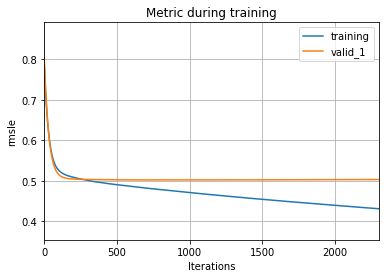

In [127]:
print('Plot metrics during training...')
ax = lgb.plot_metric(evals_result, metric='rmsle')
plt.show()

Plot feature importances...


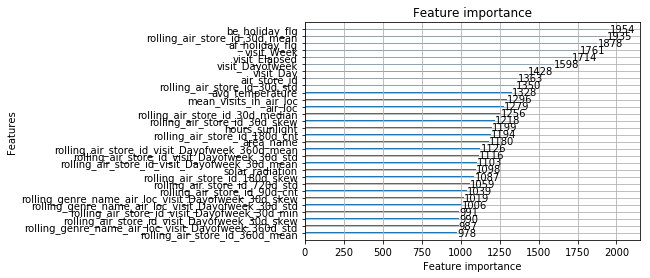

In [115]:
print('Plot feature importances...')
ax = lgb.plot_importance(gbm, max_num_features=30)
plt.show()

Plot 10th tree...


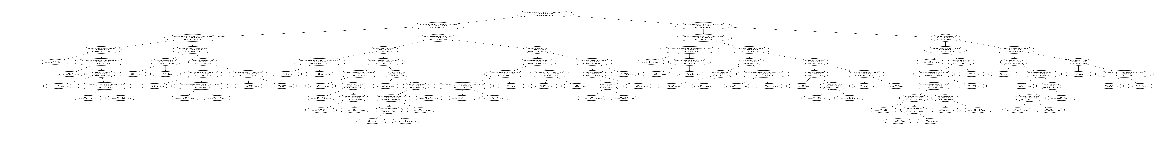

In [120]:
print('Plot 10th tree...')  # one tree use categorical feature to split
ax = lgb.plot_tree(gbm, tree_index=83, figsize=(20, 8), show_info=['split_gain'])
plt.show()

In [119]:
gbm.save_model('1st_model.txt')

In [122]:
print('Plot 84th tree with graphviz...')
graph = lgb.create_tree_digraph(gbm, tree_index=83, name='Tree84')
graph.render(view=True)

Plot 84th tree with graphviz...


'Tree84.gv.pdf'

# For Validation only

In [181]:
trn = data['tra']

In [182]:
trn_like_test = test_set.reset_index()[['air_store_id', 'visit_date', 'visitors']]
trn_like_test.visit_date = trn_like_test.visit_date.astype('str')
sub = utils.trn2test(trn_like_test)

In [184]:
sub.visitors = trn.visitors.mean()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/core/generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [185]:
sub.head()

,id,visitors
0,air_00a91d42b08b08d9_2017-04-23,20.973761
1,air_00a91d42b08b08d9_2017-04-24,20.973761
2,air_00a91d42b08b08d9_2017-04-25,20.973761
3,air_00a91d42b08b08d9_2017-04-26,20.973761
4,air_00a91d42b08b08d9_2017-04-27,20.973761


In [189]:
rmse(np.log1p(20.973761), y_valid)

0.8690054253642328

In [190]:
sub.to_csv('all_mean', index=False)

In [194]:
result = trn.groupby('air_store_id').mean().reset_index()

In [199]:
agg = pd.merge(valid_set[['air_store_id']].reset_index(), result)

In [201]:
# agg.head()
rmse(np.log1p(agg.visitors.values), y_valid)

0.6285172436351284

In [206]:
agg = pd.merge(trn_like_test[['air_store_id', 'visit_date']], result)
sub = utils.trn2test(agg)
sub.to_csv('grp_mean', index=False)

In [208]:
x = [0.5659305848785533, 0.5481404729410964, 0.8690054253642328, 0.6285172436351284]
y = [0.618 , 0.605, 0.886, 0.634]

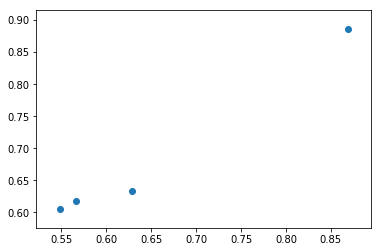

In [209]:
plt.scatter(x, y )

Yang's split is a good default

In [13]:
fi = rf_feat_importance(m, X_train); fi[:10]

,cols,imp
37,rolling_air_store_id_visit_Dayofweek_90d_mean,0.317518
76,rolling_air_store_id_visit_Dayofweek_90d_median,0.114667
52,rolling_air_store_id_visit_Dayofweek_180d_mean,0.091479
75,rolling_air_store_id_visit_Dayofweek_60d_mean,0.060703
40,rolling_air_store_id_30d_median,0.019544
85,rolling_air_store_id_30d_mean,0.017957
94,rolling_air_store_id_visit_Dayofweek_180d_median,0.016489
68,rolling_air_store_id_visit_Dayofweek_360d_median,0.014629
9,be_holiday_flg,0.010887
35,rolling_air_store_id_visit_Dayofweek_360d_mean,0.010544


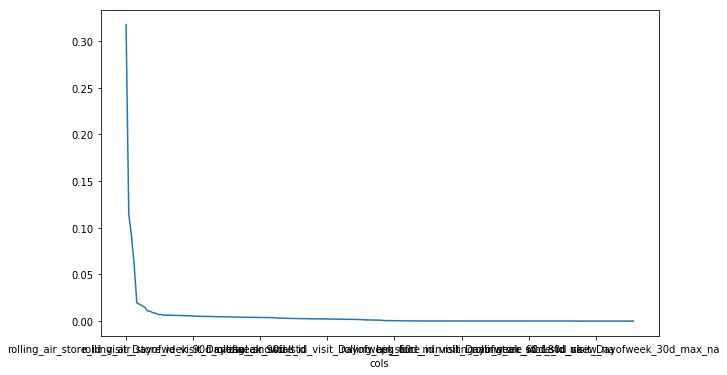

In [14]:
fi.plot('cols', 'imp', figsize=(10,6), legend=False);

In [15]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

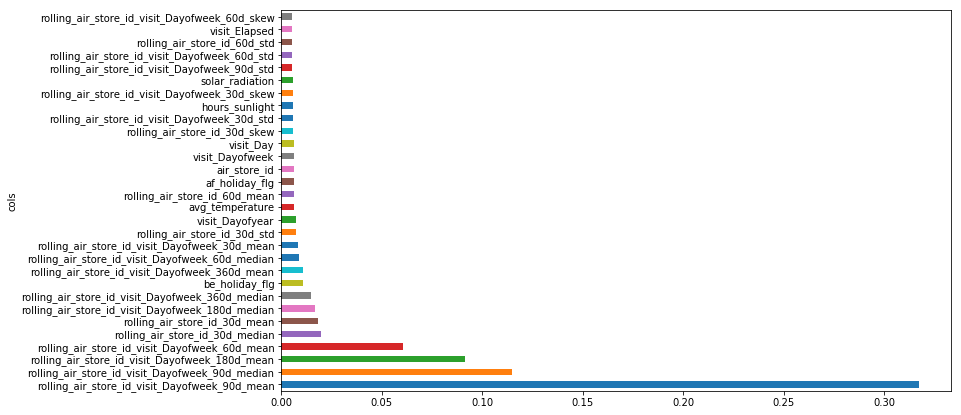

In [16]:
plot_fi(fi[:30]);

In [115]:
to_keep = fi[fi.imp>0.005].cols; 
to_keep = list(set(to_keep) - set(["visit_Dayofyear"]))
len(to_keep)

27

In [116]:
X_train, X_valid = df[to_keep].copy(), df_val[to_keep].copy()

In [124]:
m = RandomForestRegressor(n_estimators=30, min_samples_leaf=3, max_features=0.6, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.46817773054768813, 0.5664348115425176, 0.66290914916122134, 0.52731958101897236, 0.55586476982507405]


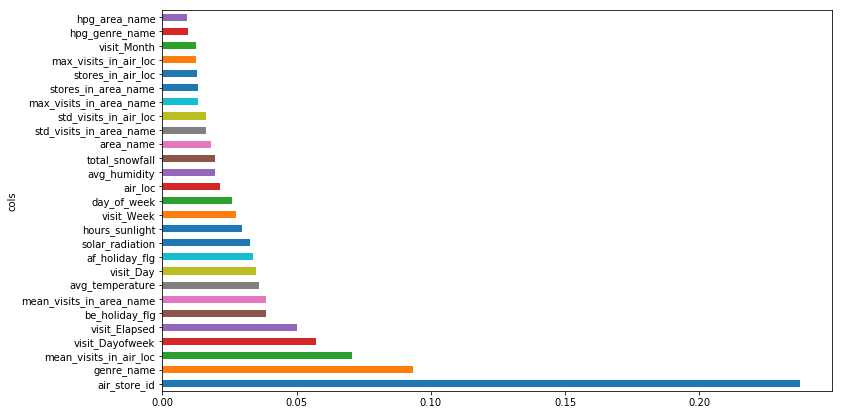

In [125]:
fi = rf_feat_importance(m, X_train)
plot_fi(fi);

In [128]:
from sklearn.externals import joblib
joblib.dump(m, '{PATH}1st.pkl') 

['{PATH}1st.pkl']

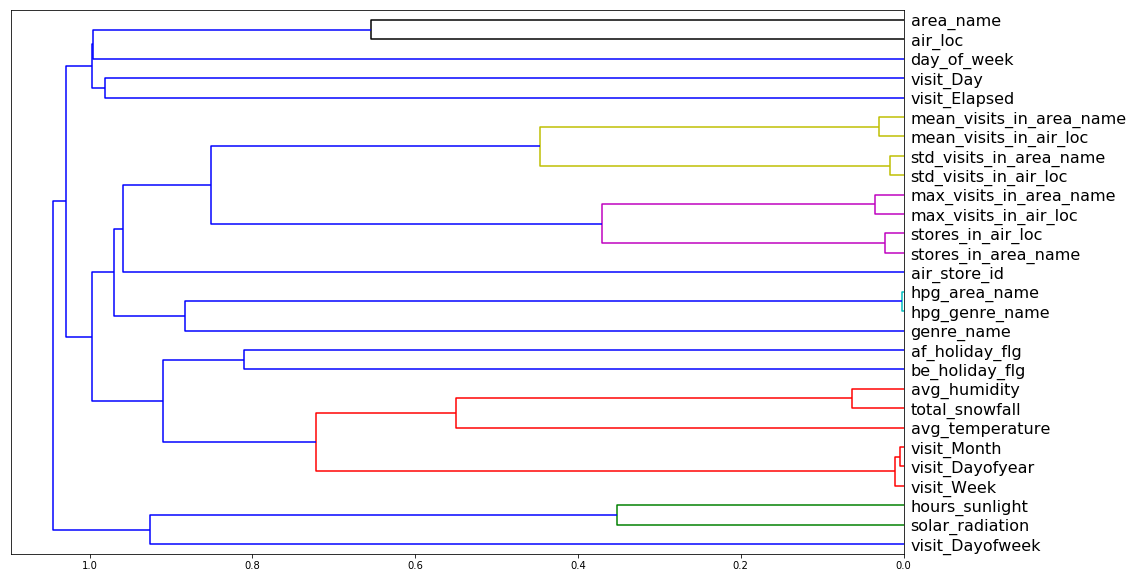

In [111]:
from scipy.cluster import hierarchy as hc

corr = np.round(scipy.stats.spearmanr(X_train).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=X_train.columns, orientation='left', leaf_font_size=16)
plt.show()

In [112]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=30, min_samples_leaf=5, max_features=0.6, n_jobs=-1, oob_score=True)
    m.fit(df, y_train)
    return m.oob_score_

In [113]:
get_oob(X_train)

0.54944460285766084

In [114]:
for c in ('hpg_area_name', 'hpg_genre_name','visit_Month', 'visit_Dayofyear'):
    print(c, get_oob(X_train.drop(c, axis=1)))

hpg_area_name 0.548242842795
hpg_genre_name 0.550920167942
visit_Month 0.549747122541
visit_Dayofyear 0.548202994228


In [33]:
reset_rf_samples()

In [34]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.36179922521130875, 0.676993103351176, 0.79869214280979817, 0.32479409983233809, 0.57243590199522287]


# Partial dependence

In [36]:
from pdpbox import pdp
from plotnine import *

In [37]:
set_rf_samples(50000)

In [38]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1)
m.fit(X_train, y_train);

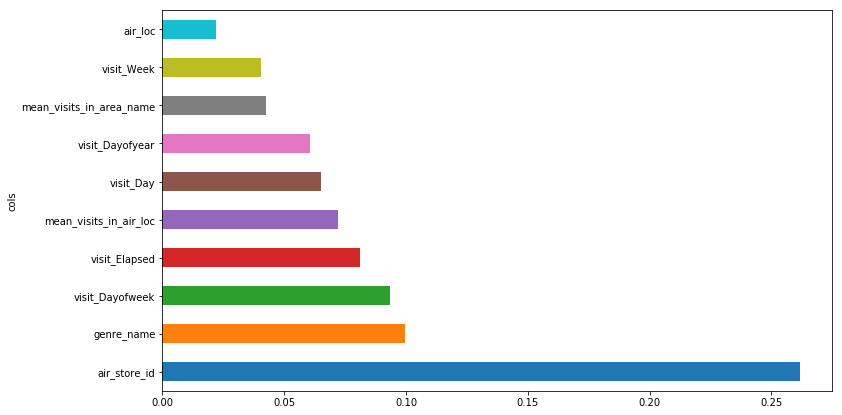

In [41]:
plot_fi(rf_feat_importance(m, X_train)[:10]);

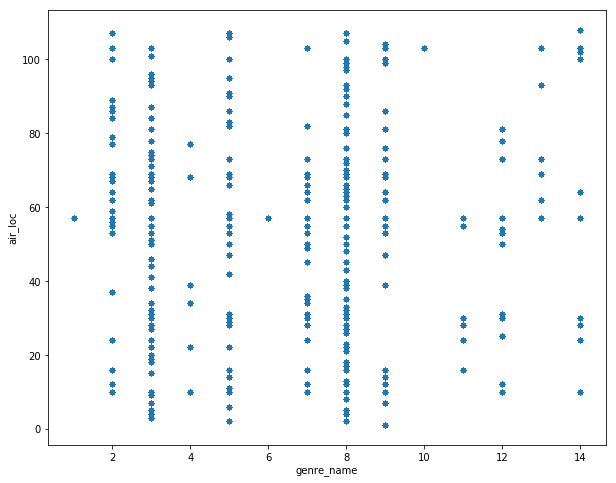

In [46]:
X_train.plot('genre_name', 'air_loc', 'scatter', alpha=0.01, figsize=(10,8));

In [ ]:
x_all = get_sample(df_raw[df_raw.YearMade>1930], 500)

In [47]:
%time preds = np.stack([t.predict(X_valid) for t in m.estimators_])
np.mean(preds[:,0]), np.std(preds[:,0])

CPU times: user 202 ms, sys: 40.7 ms, total: 243 ms
Wall time: 242 ms


(3.4392016761615194, 0.60899233236474881)

In [48]:
def get_preds(t): return t.predict(X_valid)
%time preds = np.stack(parallel_trees(m, get_preds))
np.mean(preds[:,0]), np.std(preds[:,0])

CPU times: user 87.4 ms, sys: 80.6 ms, total: 168 ms
Wall time: 304 ms


(3.4392016761615194, 0.60899233236474881)

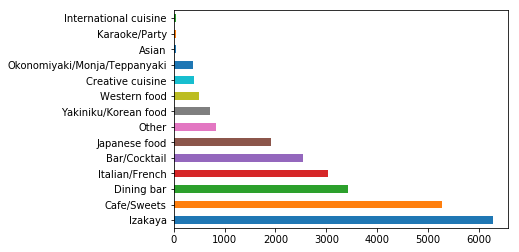

In [51]:
x = valid_set.copy()
x['pred_std'] = np.std(preds, axis=0)
x['pred'] = np.mean(preds, axis=0)
x.genre_name.value_counts().plot.barh();

In [54]:
flds = ['genre_name', 'visitors', 'pred', 'pred_std']
enc_summ = x[flds].groupby('genre_name', as_index=False).mean()
enc_summ

,genre_name,visitors,pred,pred_std
0,Asian,37.127273,2.873264,0.796646
1,Bar/Cocktail,13.279608,2.368110,0.602758
2,Cafe/Sweets,23.337569,3.009520,0.630609
3,Creative cuisine,26.486005,3.062032,0.648814
4,Dining bar,18.820835,2.752250,0.683347
5,International cuisine,26.410256,2.933772,0.870651
6,Italian/French,22.712401,2.970162,0.696028
7,Izakaya,23.771219,2.970354,0.631278
8,Japanese food,19.475616,2.883718,0.683474
9,Karaoke/Party,34.641509,3.081506,0.740399


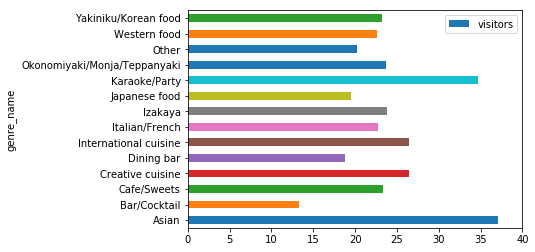

In [58]:
enc_summ = enc_summ[~pd.isnull(enc_summ.genre_name)]
enc_summ.plot('genre_name', 'visitors', 'barh', xlim=(0,40));

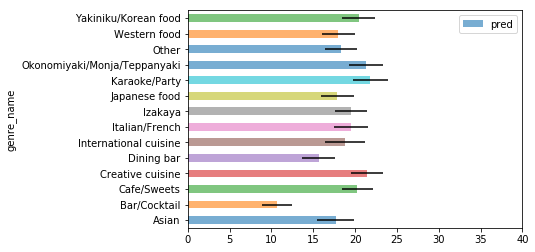

In [63]:

enc_summ.plot('genre_name', 'pred', 'barh', xerr='pred_std', alpha=0.6, xlim=(0,40));

In [ ]:
enc_summ.pred = np.exp(enc_summ.pred)

In [62]:
enc_summ.pred_std = np.exp(enc_summ.pred_std)

In [64]:
(enc_summ.pred_std/enc_summ.pred).sort_values(ascending=False)

1     0.171126
5     0.127057
4     0.126324
0     0.125353
8     0.110776
12    0.110359
11    0.104088
6     0.102886
7     0.096417
9     0.096221
13    0.095343
10    0.095107
2     0.092651
3     0.089527
dtype: float64

In [65]:
enc_summ

,genre_name,visitors,pred,pred_std
0,Asian,37.127273,17.694677,2.218089
1,Bar/Cocktail,13.279608,10.677196,1.827150
2,Cafe/Sweets,23.337569,20.277655,1.878754
3,Creative cuisine,26.486005,21.370933,1.913270
4,Dining bar,18.820835,15.677862,1.980495
5,International cuisine,26.410256,18.798410,2.388465
6,Italian/French,22.712401,19.495079,2.005771
7,Izakaya,23.771219,19.498812,1.880011
8,Japanese food,19.475616,17.880624,1.980747
9,Karaoke/Party,34.641509,21.791195,2.096772


# Tree interpreter


In [67]:
from treeinterpreter import treeinterpreter as ti

In [68]:
row = X_valid.values[None,0]; row

array([[   1.     ,    7.     ,    6.     ,  450.     ,    1.83413,   25.     ,   84.     ,    1.88624,
          12.     ,   69.     ,   45.     ,    1.40543,    1.42265,    3.     ,   -0.68605,   -0.18596,
          -0.67694,   -0.1581 ,    0.     ,   35.     ,    0.     ]])

In [69]:
prediction, bias, contributions = ti.predict(m, row)

In [70]:
prediction[0], bias[0]

(3.4392016761615194, 2.8002709957732206)

In [71]:
idxs = np.argsort(contributions[0])

In [73]:
[o for o in zip(X_train.columns[idxs], X_train.iloc[0][idxs], contributions[0][idxs])]

[('visit_Elapsed', 183.0, -0.071514926613036184),
 ('air_loc', 69.0, -0.016864963159615231),
 ('stores_in_air_loc', -0.15810222944651017, -0.012196819936200165),
 ('area_name', 45.0, -0.011989975220242621),
 ('visit_Dayofyear', 183.0, -0.0051088356225353349),
 ('hpg_genre_name', 0.0, 0.0034689967357795061),
 ('std_visits_in_area_name', 0.9717744944336782, 0.0083173268337478519),
 ('hpg_loc', 35.0, 0.012676410884746914),
 ('max_visits_in_air_loc', -0.5084147876939403, 0.013161828844448598),
 ('stores_in_area_name', -0.18596131089351278, 0.014877503610547427),
 ('genre_name', 7.0, 0.015185691376606358),
 ('visit_Month', 7.0, 0.015746843540219858),
 ('visit_Day', 1.0, 0.016314787128898268),
 ('visit_Week', 26.0, 0.020107236634243318),
 ('std_visits_in_air_loc', 0.964317762725145, 0.023366772205020658),
 ('air_store_id', 1.0, 0.025112464677193413),
 ('hpg_area_name', 0.0, 0.035259543478246724),
 ('max_visits_in_area_name', -0.5185350940077101, 0.036990592214938833),
 ('mean_visits_in_area_

In [74]:
contributions[0].sum()

0.63893068038829837

# Extrapolation

In [80]:
df_ext = pd.concat((X_train.copy(), X_valid.copy()))
df_ext['is_valid'] = 1
df_ext.is_valid[:len(X_train)] = 0
x, y, _ = proc_df(df_ext, 'is_valid')

In [81]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_

0.9988541450404842

In [82]:
fi = rf_feat_importance(m, x); fi[:10]

,cols,imp
3,visit_Elapsed,0.607622
6,visit_Dayofyear,0.082584
8,visit_Week,0.057169
14,max_visits_in_area_name,0.053746
16,max_visits_in_air_loc,0.041384
17,stores_in_air_loc,0.037159
13,visit_Month,0.026922
15,stores_in_area_name,0.020840
11,std_visits_in_air_loc,0.019514
12,std_visits_in_area_name,0.016232


In [83]:
feats=['visit_Elapsed', 'visit_Dayofyear', 'visit_Week']

In [84]:
(X_train[feats]/1000).describe()

,visit_Elapsed,visit_Dayofyear,visit_Week
count,225049.000000,225049.000000,225049.000000
mean,0.267299,0.182896,0.026270
std,0.114545,0.115288,0.016392
min,0.001000,0.001000,0.001000
25%,0.196000,0.062000,0.009000
50%,0.279000,0.202000,0.029000
75%,0.359000,0.285000,0.041000
max,0.476000,0.366000,0.053000


In [85]:
(X_valid[feats]/1000).describe()

,visit_Elapsed,visit_Dayofyear,visit_Week
count,25419.000000,25419.000000,25419.000000
mean,0.430037,0.093751,0.013671
std,0.110584,0.015042,0.002156
min,0.000000,0.035000,0.005000
25%,0.449000,0.085000,0.012000
50%,0.458000,0.095000,0.014000
75%,0.468000,0.104000,0.015000
max,0.476000,0.363000,0.052000


In [86]:
x.drop(feats, axis=1, inplace=True)

In [87]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_

0.99990018685021642

In [88]:
fi = rf_feat_importance(m, x); fi[:10]

,cols,imp
10,visit_Month,0.331620
11,max_visits_in_area_name,0.163644
13,max_visits_in_air_loc,0.117868
14,stores_in_air_loc,0.107236
9,std_visits_in_area_name,0.056961
12,stores_in_area_name,0.049920
8,std_visits_in_air_loc,0.046896
5,mean_visits_in_area_name,0.037133
3,mean_visits_in_air_loc,0.028752
6,air_loc,0.025400


In [89]:
feats=['visit_Elapsed', 'visit_Dayofyear', 'visit_Week', 'visit_Month', 'max_visits_in_area_name']

In [91]:
for f in feats:
    df_subs = X_train.drop(f, axis=1).copy()
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(df_subs, y_train)
    print(f)
    print_score(m)

visit_Elapsed


ValueError: Number of features of the model must match the input. Model n_features is 20 and input n_features is 21 

# DL

In [6]:
yl, df, y2, df_val, df_test = y_train, X_train, y_valid, X_valid, X_test

In [7]:
def inv_y(a): return np.exp(a)

def rmsle(y_pred, targ):
#     targ = inv_y(targ)
    log_vars = targ - y_pred
    return math.sqrt(np.square(log_vars).mean())

max_log_y = np.max(yl)
y_range = (0, max_log_y*1.2)

In [9]:
md = ColumnarModelData.from_data_frames(PATH, df, df_val, yl.astype(np.float32), y2.astype(np.float32), cat_flds=cat_vars, bs=128, test_df=df_test)

In [10]:
cat_sz = [(c, len(df[c].unique())+1) for c in cat_vars]
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]

In [11]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.04, 1, [1000,500], [0.001,0.01], y_range=y_range)

In [12]:
m.lr_find()


HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 96%|█████████▌| 1682/1759 [00:48<00:02, 34.45it/s, loss=1.3]] 

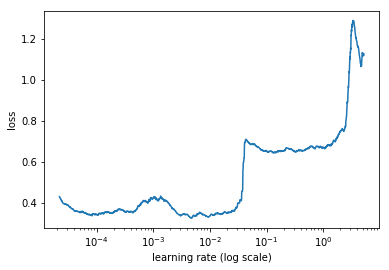

 96%|█████████▌| 1682/1759 [01:00<00:02, 28.01it/s, loss=1.3]

In [13]:
m.sched.plot(100)

In [14]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.04, 1, [1000,500], [0.001,0.01], y_range=y_range)
lr = 1e-4/1.1

In [15]:
m.fit(lr, 3, metrics=[rmsle])

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))


 11%|█         | 190/1759 [00:06<00:52, 29.62it/s, loss=0.356]


 16%|█▋        | 290/1759 [00:09<00:46, 31.55it/s, loss=0.33]


 17%|█▋        | 302/1759 [00:09<00:45, 32.09it/s, loss=0.33] 

KeyboardInterrupt: 

In [36]:
lr = 1e-4
m.fit(lr, 20, metrics=[rmsle], cycle_len=3, cycle_mult=1)

KeyboardInterrupt: 

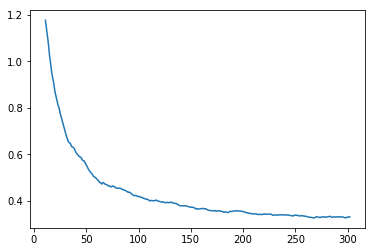

In [17]:
m.sched.plot_loss()

In [20]:
x,y=m.predict_with_targs()
rmsle(x,y)

0.5354620623609236

In [19]:
x,y=m.predict_with_targs()

In [28]:
contin_vars


['prop_yhat_lower',
 'prop_yhat_upper',
 'prop_yhat',
 'stores_in_air_loc',
 'stores_in_hpg_loc',
 'stores_in_area_name',
 'stores_in_hpg_area_name',
 'min_visits_in_air_store_id',
 'max_visits_in_air_store_id',
 'mean_visits_in_air_store_id',
 'std_visits_in_air_store_id',
 'min_visits_in_air_loc',
 'max_visits_in_air_loc',
 'mean_visits_in_air_loc',
 'std_visits_in_air_loc',
 'min_visits_in_hpg_loc',
 'max_visits_in_hpg_loc',
 'mean_visits_in_hpg_loc',
 'std_visits_in_hpg_loc',
 'min_visits_in_area_name',
 'max_visits_in_area_name',
 'mean_visits_in_area_name',
 'std_visits_in_area_name',
 'min_visits_in_hpg_area_name',
 'max_visits_in_hpg_area_name',
 'mean_visits_in_hpg_area_name',
 'std_visits_in_hpg_area_name']

In [34]:
cat_sz


[('air_store_id', 822),
 ('visit_Year', 3),
 ('visit_Month', 13),
 ('visit_Week', 54),
 ('visit_Day', 32),
 ('visit_Dayofweek', 8),
 ('visit_Dayofyear', 367),
 ('visit_Is_month_end', 3),
 ('visit_Is_month_start', 3),
 ('visit_Is_quarter_end', 3),
 ('visit_Is_quarter_start', 3),
 ('visit_Is_year_end', 3),
 ('visit_Is_year_start', 3),
 ('visit_Elapsed', 477),
 ('day_of_week', 8),
 ('holiday_flg', 3),
 ('af_holiday_flg', 75),
 ('be_holiday_flg', 75),
 ('dur_time_holiday_flg', 8),
 ('dur_holiday_flg', 6),
 ('dur_prog_holiday_flg', 8),
 ('genre_name', 15),
 ('area_name', 72),
 ('hpb_genre_name', 16),
 ('hpb_area_name', 33),
 ('air_loc', 74),
 ('hpb_loc', 34)]

In [387]:
csv_fn=f'sub1.csv'
pred_test=m.predict(True)
pred_test = np.exp(pred_test)
test_set['visitors']=pred_test
sub = utils.trn2test(test_set.reset_index()[['air_store_id', 'visit_date', 'visitors']])
sub.to_csv(csv_fn, index=False)

In [388]:
FileLink(csv_fn)


/notebooks/sub1.csv

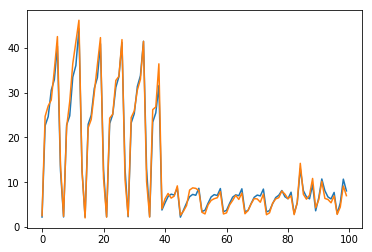

In [326]:
plt.plot(test_set.prop_yhat.values[:100])
plt.plot(pred_test[:100])

In [95]:
np.exp(0.044)

1.0449823548884438

In [96]:
np.exp(np.log1p(30) - 0.044)

29.665572681664447